In [83]:
from nba_api.live.nba.endpoints import scoreboard

# Today's Score Board
games = scoreboard.ScoreBoard()

# json
games.get_json()

# dictionary
games.get_dict()

{'meta': {'version': 1,
  'request': 'https://nba-prod-us-east-1-mediaops-stats.s3.amazonaws.com/NBA/liveData/scoreboard/todaysScoreboard_00.json',
  'time': '2023-09-27 07:37:04.374',
  'code': 200},
 'scoreboard': {'gameDate': '2023-09-26',
  'leagueId': '00',
  'leagueName': 'National Basketball Association',
  'games': []}}

In [84]:
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

teams = teams.get_teams()
#print(teams)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]
#filter data for just the start_date = pd.to_datetime('1979-10-01') end_date = pd.to_datetime('2024-06-30')
all_games = all_games[all_games.GAME_DATE <= '2023-06-30']
all_games = all_games[all_games.GAME_DATE >= '2022-10-01']
#print(all_games.head())

#get unique team IDs and team names and year in the same frame
team_ids = all_games[['TEAM_ID', 'TEAM_NAME']].drop_duplicates().sort_values('TEAM_ID').reset_index(drop=True)
#print(team_ids)

# List of current NBA team IDs using the team_ids dataframe
#current_teams = team_ids['TEAM_ID'].tolist()
current_teams = [1610612739, 1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

#serach for Teams to get their team id: in team_name column
#print(team_ids[team_ids['TEAM_NAME'] == 'Cleveland Cavaliers'])


# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]

# get unique list of team_id, team_name, and season_id as a copy so we can save it to data folder
team_ids = data[['TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION']].drop_duplicates().sort_values('TEAM_ID').reset_index(drop=True)
#print(team_ids)
unique_team_season_id = team_ids.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv', index=False)

#check the team_id and season_id types
print(data['TEAM_ID'].dtype)
print(data['SEASON_ID'].dtype)


# Function to determine home or away
def home_or_away(row):
    team = row['TEAM_ABBREVIATION']
    matchup = row['MATCHUP']
    
    if team + ' @ ' in matchup:
        return 'Away'
    elif team + ' vs. ' in matchup:
        return 'Home'
    else:
        return 'Unknown'
    
data['Home_Away'] = data.apply(home_or_away, axis=1)

#fix index
data = data.reset_index(drop=True)
print(len(data))
print(data.head())
print(data.columns)

int64
object
2772
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  \
0     42022  1610612743               DEN  Denver Nuggets  0042200405   
1     42022  1610612748               MIA      Miami Heat  0042200405   
2     42022  1610612743               DEN  Denver Nuggets  0042200404   
3     42022  1610612748               MIA      Miami Heat  0042200404   
4     42022  1610612748               MIA      Miami Heat  0042200403   

    GAME_DATE      MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  FG3M  FG3A  \
0  2023-06-12  DEN vs. MIA  W  240   94   38   84   0.452     5    28   
1  2023-06-12    MIA @ DEN  L  240   89   33   96   0.344     9    35   
2  2023-06-09    DEN @ MIA  W  242  108   39   79   0.494    14    28   
3  2023-06-09  MIA vs. DEN  L  240   95   35   78   0.449     8    25   
4  2023-06-07  MIA vs. DEN  L  240   94   34   92   0.370    11    35   

   FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  \
0    0.179   13   23   0.565   

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31728\228647623.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Home_Away'] = data.apply(home_or_away, axis=1)


In [85]:

# Assuming data is your original dataframe

# Splitting data into data_first and data_second
data_first = data#.iloc[::2].reset_index(drop=True)
data_second = data#.iloc[1::2].reset_index(drop=True)

# Drop unnecessary columns from data_second
columns_to_drop = ['GAME_DATE', 'MATCHUP', 'TEAM_ABBREVIATION']
data_second = data_second.drop(columns=columns_to_drop)

# Merge data_first and data_second
data = data_first.merge(data_second, on='GAME_ID', suffixes=('', '_OPP'))

# Ensure TEAM_NAME from data_first isn't the same as TEAM_NAME from data_second
data = data[data.TEAM_NAME != data.TEAM_NAME_OPP]

print(len(data))
print(data.head())


2768
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  \
1     42022  1610612743               DEN  Denver Nuggets  0042200405   
2     42022  1610612748               MIA      Miami Heat  0042200405   
5     42022  1610612743               DEN  Denver Nuggets  0042200404   
6     42022  1610612748               MIA      Miami Heat  0042200404   
9     42022  1610612748               MIA      Miami Heat  0042200403   

    GAME_DATE      MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  FG3M  FG3A  \
1  2023-06-12  DEN vs. MIA  W  240   94   38   84   0.452     5    28   
2  2023-06-12    MIA @ DEN  L  240   89   33   96   0.344     9    35   
5  2023-06-09    DEN @ MIA  W  242  108   39   79   0.494    14    28   
6  2023-06-09  MIA vs. DEN  L  240   95   35   78   0.449     8    25   
9  2023-06-07  MIA vs. DEN  L  240   94   34   92   0.370    11    35   

   FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  \
1    0.179   13   23   0.565    11    46   5

In [86]:
# Filtering data for testing ("fake incoming" data from '2023-05-01' to '2023-06-30')
test_data = data[(data.GAME_DATE > '2023-04-30') & (data.GAME_DATE <= '2023-06-30')]

#export to csv
data.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv', index=False)


In [87]:
#data adds: playoff indicator, championship indicator, conference indicator, division indicator 

import pandas as pd

def prepare_data(df):
    # Sum the statistics by team and season_id
    sum_data = df.groupby(['TEAM_ID', 'Home_Away']).agg({
        'PTS': 'sum',
        'FGM': 'sum',
        'FGA': 'sum',
        'FG3M': 'sum',
        'FG3A': 'sum',
        'FTM': 'sum',
        'FTA': 'sum',
        'AST': 'sum',
        'OREB': 'sum',
        'TOV': 'sum',
        'STL': 'sum',
        'BLK': 'sum',
        'REB': 'sum',
        'PLUS_MINUS': 'mean'  # Mean of the PLUS_MINUS remains as is
        , 'PTS_OPP': 'sum'
        , 'FGM_OPP': 'sum'
        , 'FGA_OPP': 'sum'
        , 'FG3M_OPP': 'sum'
        , 'FG3A_OPP': 'sum'
        , 'FTM_OPP': 'sum'
        , 'FTA_OPP': 'sum'
        , 'AST_OPP': 'sum'
        , 'OREB_OPP': 'sum'
        , 'TOV_OPP': 'sum'
        , 'STL_OPP': 'sum'
        , 'BLK_OPP': 'sum'
        , 'REB_OPP': 'sum'
        , 'PLUS_MINUS_OPP': 'mean'  # Mean of the PLUS_MINUS remains as is
    }).reset_index()
    
    # Calculate FG, FG3, and FT percentages
    sum_data['FG_PCT'] = sum_data['FGM'] / sum_data['FGA']
    sum_data['FG3_PCT'] = sum_data['FG3M'] / sum_data['FG3A']
    sum_data['FT_PCT'] = sum_data['FTM'] / sum_data['FTA']
    
    # Calculate additional stats
    sum_data['TS%'] = sum_data['PTS'] / (2 * (sum_data['FGA'] + 0.44 * sum_data['FTA']))
    sum_data['eFG%'] = (sum_data['FGM'] + 0.5 * sum_data['FG3M']) / sum_data['FGA']
    sum_data['AST%'] = (sum_data['AST'] / sum_data['FGA']) * 100
    
    # Calculate offensive possessions: https://kenpom.com/blog/the-possession/
    sum_data['Offensive_Possessions'] = (sum_data['FGA'] - sum_data['OREB']) + sum_data['TOV'] + (0.44 * sum_data['FTA'])

    # Calculate Offensive Rating (ORtg) and Player Efficiency Rating (PER)
    sum_data['ORtg'] = (sum_data['PTS'] / sum_data['Offensive_Possessions']) * 100
    # Offensive Team Rating (https://www.basketball-reference.com/about/ratings.html) = (Players Points*Total FG%) + Opponents Differential= 1/5 of possessions - Times Fouled+ FTM* FT% * OAPOW (Official Adjusted Players Offensive Withstand)

    sum_data['PER%'] = ((sum_data['PTS'] + sum_data['REB'] + sum_data['AST'] + sum_data['STL'] + sum_data['BLK'] -
                         sum_data['FGM'] - sum_data['FTM'] - sum_data['TOV']) / sum_data['Offensive_Possessions']) * 100

    #_OPP stats:
    # Calculate FG, FG3, and FT percentages
    sum_data['FG_PCT_OPP'] = sum_data['FGM_OPP'] / sum_data['FGA_OPP']
    sum_data['FG3_PCT_OPP'] = sum_data['FG3M_OPP'] / sum_data['FG3A_OPP']
    sum_data['FT_PCT_OPP'] = sum_data['FTM_OPP'] / sum_data['FTA_OPP']
    
    # Calculate additional stats
    sum_data['TS%_OPP'] = sum_data['PTS_OPP'] / (2 * (sum_data['FGA_OPP'] + 0.44 * sum_data['FTA_OPP']))
    sum_data['eFG%_OPP'] = (sum_data['FGM_OPP'] + 0.5 * sum_data['FG3M_OPP']) / sum_data['FGA_OPP']
    sum_data['AST%_OPP'] = (sum_data['AST_OPP'] / sum_data['FGA_OPP']) * 100

    # Calculate Defensive possessions _OPP
    sum_data['Defensive_Possessions'] = (sum_data['FGA_OPP'] - sum_data['OREB_OPP']) + sum_data['TOV_OPP'] + (0.44 * sum_data['FTA_OPP'])

    # Calculate Defensive Rating (DRtg)
    sum_data['DRtg'] = (sum_data['PTS_OPP'] / sum_data['Defensive_Possessions']) * 100

    sum_data['DPER%'] = ((sum_data['PTS_OPP'] + sum_data['REB_OPP'] + sum_data['AST_OPP'] + sum_data['STL_OPP'] + sum_data['BLK_OPP'] -
                         sum_data['FGM_OPP'] - sum_data['FTM_OPP'] - sum_data['TOV_OPP']) / sum_data['Defensive_Possessions']) * 100


    return sum_data

prepared_data = prepare_data(data)
#print(prepared_data.head())


data_drop_columns = ['PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 'OREB', 'FGA', 'FG3A', 'OREB', 
                                    'AST', 'TOV', 'STL', 'BLK',  'Offensive_Possessions', 'SEASON_ID'
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP',  'Defensive_Possessions', 'SEASON_ID_OPP', 'Home_Away_OPP'] #, 'DREB'

#export the data dataset without the dropped columns
future_season_data_stats = prepared_data[[col for col in prepared_data.columns if col not in data_drop_columns]]

# export X to csv to apply averages onto future nba season data on a long short-term basis
future_season_data_stats.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\future_season_data_stats.csv', index=False)
print(future_season_data_stats.head())
print(len(future_season_data_stats))

      TEAM_ID Home_Away  PLUS_MINUS  PLUS_MINUS_OPP    FG_PCT   FG3_PCT  \
0  1610612737      Away   -1.587500        1.725000  0.477892  0.356283   
1  1610612737      Home    2.088889       -2.088889  0.482987  0.351759   
2  1610612738      Away    2.776923       -2.819231  0.466724  0.374264   
3  1610612738      Home    9.129630       -9.129630  0.484382  0.375166   
4  1610612739      Away    1.533333       -1.533333  0.480794  0.365217   

     FT_PCT       TS%      eFG%       AST%        ORtg        PER%  \
0  0.808372  0.576064  0.538946  26.964490  113.662316  118.943719   
1  0.818544  0.577641  0.540879  26.866730  114.766853  121.909224   
2  0.814433  0.590361  0.556254  29.525255  114.995171  126.473609   
3  0.810000  0.608431  0.573660  30.202617  117.319663  127.554010   
4  0.783181  0.581633  0.546642  28.142148  113.140452  118.869372   

   FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP   TS%_OPP  eFG%_OPP   AST%_OPP  \
0    0.486284     0.374074    0.796313  0.593874  0.557

has_23_24_schedule =  False
     SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME  \
5537     12022  1610612749               MIL        Milwaukee Bucks   
5538     12022  1610612763               MEM      Memphis Grizzlies   
5524     12022  1610612764               WAS     Washington Wizards   
5525     12022  1610612744               GSW  Golden State Warriors   
5520     12022  1610612738               BOS         Boston Celtics   
...        ...         ...               ...                    ...   
10       42022  1610612743               DEN         Denver Nuggets   
5        42022  1610612743               DEN         Denver Nuggets   
6        42022  1610612748               MIA             Miami Heat   
1        42022  1610612743               DEN         Denver Nuggets   
2        42022  1610612748               MIA             Miami Heat   

         GAME_ID  GAME_DATE      MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  FG3M  \
5537  0012200003 2022-10-01  MIL vs. M

C:\Users\ghadf\AppData\Local\Temp\ipykernel_31728\3859929665.py:141: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = season_data.corr()


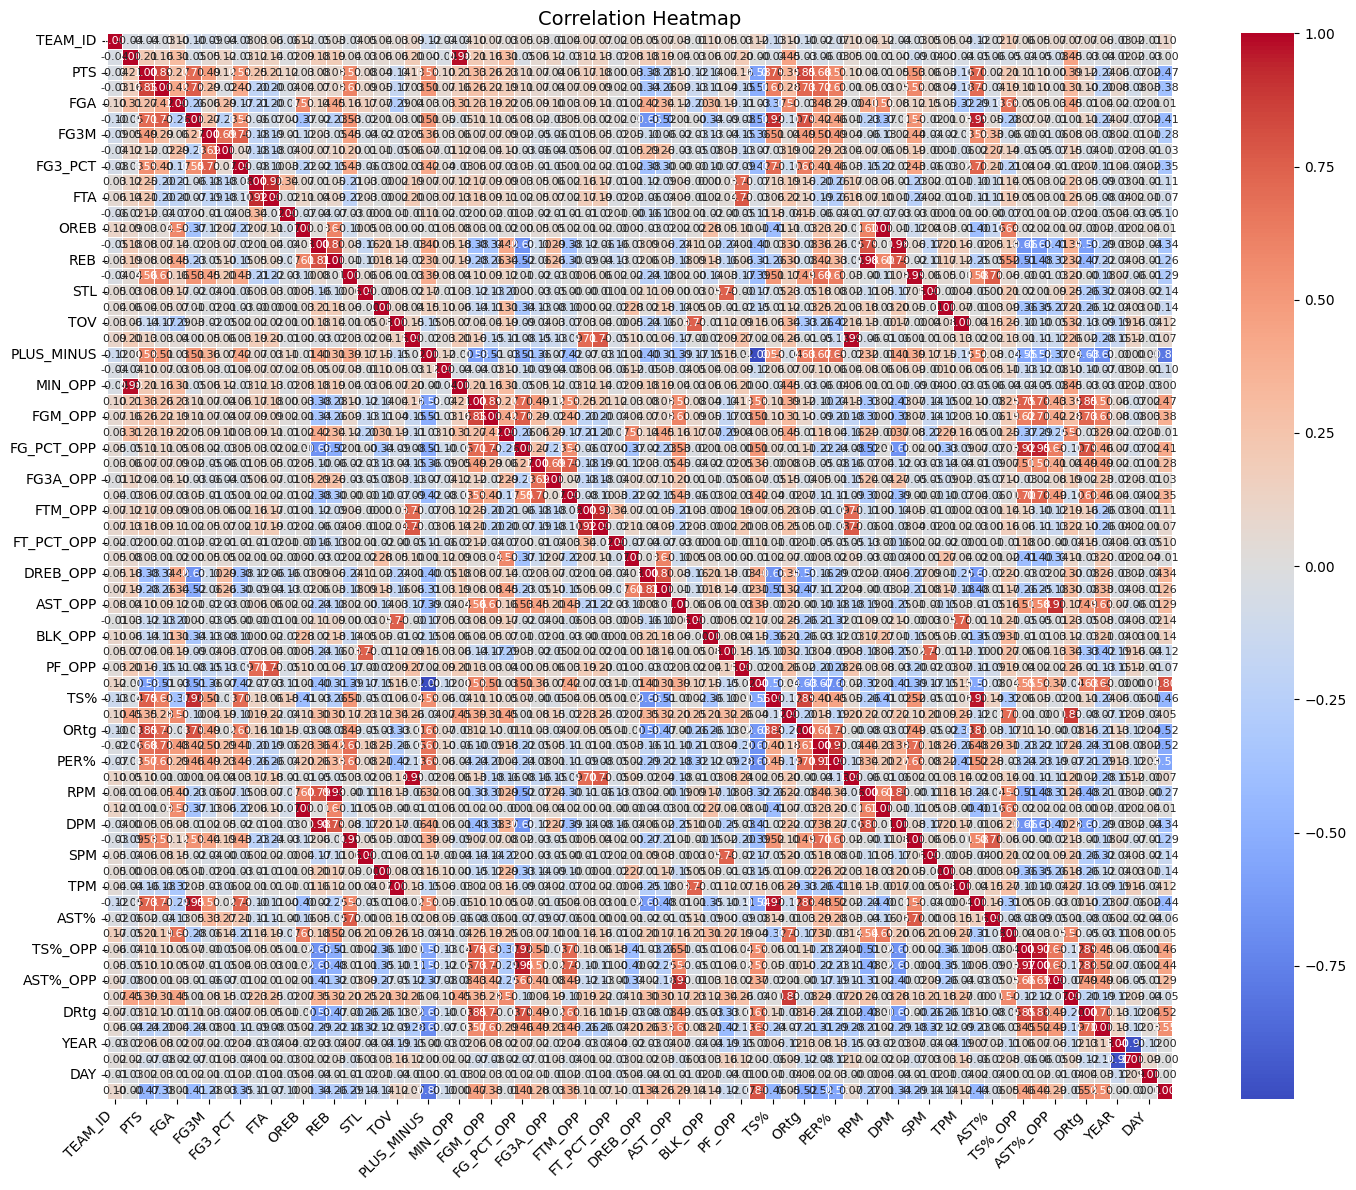

In [88]:

#print('base_data = ',data.columns)
#print(data.head())
#stat addons list: PER, TS%, eFG%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP
#adding TS%= PTS / (2 * (FGA + 0.44 * FTA))
data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))



#**OFF Rating add
# Calculate offensive and defensive possessions
data['Offensive_Possessions'] = data['FGA'] + 0.44 * data['FTA'] + data['TOV'] - data['OREB']
#data['Defensive_Possessions'] = data['Opponent_FGA'] + 0.44 * data['Opponent_FTA'] + data['Opponent_TOV'] - data['Opponent_OREB']

# Calculate Offensive Rating and Defensive Rating
data['ORtg'] = (data['PTS'] / data['Offensive_Possessions']) * 100
#data['DRtg'] = (data['Points_Allowed'] / data['Defensive_Possessions']) * 100

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / MIN
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])/ data['MIN']
#standardized to 48 minutes
#data['PER%'] = (data['PER'] / data['MIN']) * 48

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / OP
data['PER%'] = ((data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV']) / data['Offensive_Possessions']) * 100

# add per min function
def per_min(col):
    # Create a new column name based on the input column's name
    column_pm = col.name[0] + 'PM'
    
    # Set the new column's values to the per-minute values of the input column
    data[column_pm] = col / data['MIN']

#add points per minute  
#data['PPM'] = data['PTS'] / data['MIN']
per_min(data['PTS'])

#adding rebounds per minute
#data['RPM'] = data['REB'] / data['MIN']
per_min(data['REB'])
per_min(data['OREB'])
per_min(data['DREB'])

#adding assists per minute
#data['APM'] = data['AST'] / data['MIN']
per_min(data['AST'])

#adding steals per minute
#data['SPM'] = data['STL'] / data['MIN']
per_min(data['STL'])

#adding blocks per minute
#data['BPM'] = data['BLK'] / data['MIN']
per_min(data['BLK'])

#adding turnovers per minute
#data['TPM'] = data['TOV'] / data['MIN']
per_min(data['TOV'])

#adding fouls per minute
#data['FPM'] = data['PF'] / data['MIN']
per_min(data['PF'])

#adding eFG%
data['eFG%'] = (data['FGM'] + 0.5 * data['FG3M']) / data['FGA']

#adding AST%
data['AST%'] = data['AST'] / data['FGM']

#adding USG%
data['USG%'] = (data['FGA'] + 0.44 * data['FTA'] + data['TOV']) / data['MIN']
#add all the percentages to the list of columns

#_OPP stats:
# Calculate FG, FG3, and FT percentages
data['FG_PCT_OPP'] = data['FGM_OPP'] / data['FGA_OPP']
data['FG3_PCT_OPP'] = data['FG3M_OPP'] / data['FG3A_OPP']
data['FT_PCT_OPP'] = data['FTM_OPP'] / data['FTA_OPP']

# Calculate additional stats
data['TS%_OPP'] = data['PTS_OPP'] / (2 * (data['FGA_OPP'] + 0.44 * data['FTA_OPP']))
data['eFG%_OPP'] = (data['FGM_OPP'] + 0.5 * data['FG3M_OPP']) / data['FGA_OPP']
data['AST%_OPP'] = (data['AST_OPP'] / data['FGA_OPP']) * 100

# Calculate Defensive possessions _OPP
data['Defensive_Possessions'] = (data['FGA_OPP'] - data['OREB_OPP']) + data['TOV_OPP'] + (0.44 * data['FTA_OPP'])

# Calculate Defensive Rating (DRtg)
data['DRtg'] = (data['PTS_OPP'] / data['Defensive_Possessions']) * 100

data['DPER%'] = ((data['PTS_OPP'] + data['REB_OPP'] + data['AST_OPP'] + data['STL_OPP'] + data['BLK_OPP'] -
                        data['FGM_OPP'] - data['FTM_OPP'] - data['TOV_OPP']) / data['Defensive_Possessions']) * 100


#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Drop Missing values
# Drop rows with missing values
data_encoded = data.dropna()

# Filter the data to include only selected columns
#data_encoded_selected = data_encoded.iloc[:, :40]

# Check if the 2022-2023 NBA season is in the data. previous year was released on 8/17, see if in data then
has_23_24_schedule = any(data_encoded['SEASON_ID'] == 42023)
print('has_23_24_schedule = ',has_23_24_schedule)


# Filter the data for the 2022-2023 NBA season - changing to 1979-2023
#could also use season_id = 42022
start_date = pd.to_datetime('1979-10-01')
end_date = pd.to_datetime('2024-06-30')
season_data = data_encoded[(data_encoded['GAME_DATE'] >= start_date) & (data_encoded['GAME_DATE'] <= end_date)].copy()

#sort season_data by game_id and game_date
#proof that the dataset is team stats per game and not combined team stats per game
season_data = season_data.sort_values(by=['GAME_DATE','GAME_ID'])


# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
season_data['WL_encoded'] = season_data['WL_OPP'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data)


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
season_data = season_data[[col for col in season_data.columns if col != 'WL_encoded'] + ['WL_encoded']]

# Create a correlation matrix for the selected columns
correlation_matrix = season_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 8}, linewidths=.5)  # Adjust the font size of annotations

plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x labels for better visibility
plt.yticks(rotation=0, fontsize=10)  # Adjust the y labels font size for clarity
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()  # Adjust the layout to fit the labels better
plt.show()


#In this code, we reorder the columns of season_data so that the target variable 'WL_encoded' is at the end. 
# Then, we calculate the correlation matrix using season_data.corr() and plot the heatmap using sns.heatmap(). 
# The heatmap will show the correlation values between different variables, with positive correlations in warmer colors and negative 
# correlations in cooler colors. The annot=True parameter shows the actual correlation values on the heatmap, and fmt='.2f' formats 
# the numbers to two decimal places. The cmap='coolwarm' parameter sets the color scheme for the heatmap.


In [89]:
# Find out which columns have NaN values and the number of NaN values in each column
nan_values = data.isnull().sum()
nan_columns_before = nan_values[nan_values > 0]

print("Columns with NaN values and their counts before dropping:")
print(nan_columns_before)

# Drop columns with NaN values
data = data.dropna(axis=1)

# Check NaN columns again after dropping
nan_values_after = data.isnull().sum()
nan_columns_after = nan_values_after[nan_values_after > 0]

print("\nColumns with NaN values and their counts after dropping:")
print(nan_columns_after)


Columns with NaN values and their counts before dropping:
Series([], dtype: int64)

Columns with NaN values and their counts after dropping:
Series([], dtype: int64)


In [90]:
# Save the data to a CSV file
season_data.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_prepreprocess_data.csv', index=False)


